In [ ]:
from torch import nn
import numpy as np
import time
#from IPython import display
import os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
import torch
import random
from torch.nn import functional as F

In [ ]:
#input data
wudongde = pd.read_excel(r'E:\sklearn\hydraulic script\with  storages -with 5 fixed storages -change 2 cross sections\wudongde.xlsx', sheet_name=0, index_col='Time')
wudongde = np.array(wudongde)
wudongde = pd.DataFrame(wudongde)
wudongde[0] = pd.to_datetime(wudongde[0])  
wudongde.sort_values(by=[0], inplace=True, ascending=True)

In [6]:
Q = np.array(wudongde['Q'], dtype = 'float32')
H = np.array(wudongde['H'], dtype = 'float32')

In [7]:
#data slicing
def seq_data_iter_random(H, Q, batch_size, num_steps):
    a = random.randint(0, num_steps - 1)
    H, Q = H[a:], Q[a:]
    num_subseqs = len(H) - num_steps 
    initial_indices = list(range(0, num_subseqs))
    random.shuffle(initial_indices)

    def data1(pos):
        return H[pos: pos + num_steps]
    def data2(pos):
        return Q[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data1(j) for j in initial_indices_per_batch]
        Y = [data2(j) for j in initial_indices_per_batch]
        yield torch.tensor(np.array(X)), torch.tensor(np.array(Y))
        
def seq_data_iter_sequential(H, Q, batch_size, num_steps):  # @save

    offset = 0
    H, Q = H[offset:], Q[offset:]
    num_subseqs = len(H) - num_steps
    initial_indices = list(range(0, num_subseqs))

    def data1(pos):
        return H[pos: pos + num_steps]
    def data2(pos):
        return Q[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data1(j) for j in initial_indices_per_batch]
        Y = [data2(j) for j in initial_indices_per_batch]
        yield torch.tensor(np.array(X)), torch.tensor(np.array(Y))
        
class SeqDataLoader:
    """加载序列数据的迭代器"""

    def __init__(self, H, Q, batch_size, num_steps, use_random_iter):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.H = H
        self.Q = Q
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.H, self.Q, self.batch_size, self.num_steps)


def load_data(H, Q, batch_size, num_steps, use_random_iter=False):
    """返回数据集的迭代器"""
    data_iter = SeqDataLoader(H, Q, batch_size, num_steps, use_random_iter)
    return data_iter

In [8]:
class Accumulator:

    def __init__(self, n): 
        self.data = [0.0] * n  

    def add(self, *args): 
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self): 
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):  
        return self.data[idx]


class Timer:

    def __init__(self):
        self.tik = None
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def sum(self):
        return sum(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        plt.draw()
        plt.pause(0.001)
        display.clear_output(wait=True)

In [9]:
#neural network
class RNNModel(nn.Module):

    def __init__(self, rnn_layer, num_layer, input_size, num_hiddens, output_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)

        self.rnn = rnn_layer(input_size, num_hiddens, num_layer, bidirectional=True)
        self.input_size = self.rnn.input_size
        self.num_hiddens = self.rnn.hidden_size

        self.output_size = output_size

        
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.output_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.output_size)

    def forward(self, inputs, state):

        Y, state = self.rnn(inputs, state)

        m = nn.Hardtanh(-1, 1)

        output = self.linear(m(Y.reshape((-1, Y.shape[-1]))))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):

            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),
                               device=device)
        else:

            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),
                                device=device))

In [10]:
#train 
def train_epoch(net, train_iter, loss, updater, scheduler, device, use_random_iter):
    
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.train()
    timer = Timer()
    state = None
    metric = Accumulator(2)

    for X, Y in train_iter:
        # x shape（batch_size, num_steps, input_size）
        # y shape（batch_size, num_steps, output_size）
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()

        y = Y.mT.reshape(-1)
        X = X.mT.reshape(X.shape[1], X.shape[0], -1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)

        l = loss(y_hat.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
        
        metric.add(l * y.shape[0], y.shape[0])
                
        scheduler.step()
    
    return metric[0] / metric[1], metric[1] / timer.stop()

In [11]:
def evaluate_accuracy_epoch(net, test_iter, loss, device, use_random_iter):
    net.eval()
    state, timer = None, Timer()
    metric = Accumulator(2)

    #eval
    with torch.no_grad():

        for X, Y in test_iter:
        # x shape（batch_size, num_steps, input_size）
        # y shape（batch_size, num_steps, output_size）
            if state is None or use_random_iter:
                state = net.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(net, nn.Module) and not isinstance(state, tuple):
                    state.detach_()
                else:
                    for s in state:
                        s.detach_()
            y = Y.T.reshape(-1)
            X = X.T.reshape(X.shape[1], X.shape[0], -1)
            X, y = X.to(device), y.to(device)
            y_hat, state = net(X, state)
            l = loss(y_hat, y)
        metric.add(l * y.shape[0], y.shape[0])
    return metric[0] / metric[1]

In [12]:
# train
def train(net, train_iter, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.MSELoss(reduction='mean')

    #adjust lr
    scheduler = torch.optim.lr_scheduler.MultiStepLR(updater, milestones=[100], gamma=0.1)
    loss_process = []

    # train
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        train_loss, speed = train_epoch(net, train_iter, loss, updater, scheduler, device, use_random_iter)
        #test_loss = evaluate_accuracy_epoch(net, test_iter, loss, device, use_random_iter)
        # if (epoch + 1) % 10 == 0:
        #animator.add(epoch + 1, [train_loss, test_loss])
        train_loss_real = scaler_Q.inverse_transform(np.array(train_loss).reshape(-1, 1))
        loss_process.append(train_loss)
        
        print(f'{str(device)}\t{speed} tokens/sec\ntrain_loss_real\t\t{float(train_loss_real)}\ntrain_loss_normal\t{train_loss}')

In [13]:
#gradient clipping
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [14]:
#preprocess
from sklearn.preprocessing import MinMaxScaler
scaler_H = MinMaxScaler(feature_range=(0, 10))
scaler_Q = MinMaxScaler(feature_range=(0, 10))

H_norm = scaler_H.fit_transform(H.reshape(-1, 1))
Q_norm = scaler_Q.fit_transform(Q.reshape(-1, 1))

H_norm_train = H_norm[8760*3:8760*4]
Q_norm_train = Q_norm[8760*3:8760*4]
H_norm_test = H_norm[8760*2:8760*3]
Q_norm_test = Q_norm[8760*2:8760*3]

In [15]:
batch_size = 24
num_steps = 72
train_iter = load_data(H_norm_train, Q_norm_train, batch_size, num_steps, use_random_iter=True)
test_iter = load_data(H_norm_test, Q_norm_test, batch_size, num_steps, use_random_iter=False)

In [22]:
#check
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'-------------------------------\n'
      f'Using {device} device\n'
      f'-------------------------------')

num_layer = 1
num_hiddens = 128
num_epochs = 20000
learning_rate = 0.01
output_size = 1
use_random_iter = True
input_size = 1

LSTM_net = RNNModel(nn.LSTM, num_layer, input_size, num_hiddens, output_size)
GRU_net = RNNModel(nn.GRU, num_layer, input_size, num_hiddens, output_size)
RNN_net = RNNModel(nn.RNN, num_layer, input_size, num_hiddens, output_size)

net = GRU_net.to(device)
updater = torch.optim.Adam(net.parameters(), learning_rate)

train(net, train_iter, learning_rate, num_epochs, device, use_random_iter=use_random_iter)

In [35]:
#save model
torch.save(net.state_dict(), 'BiGRU_bs_1_timestep_72_num_hiddens_128_layers_1_wudongde.ckpt')

In [ ]:
#before load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_layer = 2
num_hiddens = 128
num_epochs = 20000
learning_rate = 0.001
output_size = 1
use_random_iter = True
input_size = 1

LSTM_net = RNNModel(nn.LSTM, num_layer, input_size, num_hiddens, output_size)
GRU_net = RNNModel(nn.GRU, num_layer, input_size, num_hiddens, output_size)
RNN_net = RNNModel(nn.RNN, num_layer, input_size, num_hiddens, output_size)

net = RNN_net.to(device)
updater = torch.optim.Adam(net.parameters(), learning_rate)
net.load_state_dict(torch.load('RNN_timestep_72_num_hiddens_128_layers_1_steady_train_oneyear.ckpt'))

<All keys matched successfully>

In [53]:
#load model
net = torch.load('BiRNN_timestep_72_num_hiddens_128_layers_1_steady_train_oneyear.ckpt')

In [19]:
#retrain
def train_epoch_continue(net, train_iter, loss, updater, scheduler, device, use_random_iter):
    
    state = net.state_dict()
    updater.load_state_dict(updater.state_dict())
    net.train()
    timer = Timer()
    metric = Accumulator(2)

    for X, Y in train_iter:

        if state is None or use_random_iter:

            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):

                state.detach_()
            else:

                for s in state:
                    s.detach_()

        y = Y.mT.reshape(-1)
        X = X.mT.reshape(X.shape[1], X.shape[0], -1)
        X, y = X.to(device), y.to(device)

        y_hat, state = net(X, state)
        l = loss(y_hat.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        #grad_clipping(net, 1)
        updater.step()
        
        metric.add(l * y.shape[0], y.shape[0])

    
    return metric[0] / metric[1], metric[1] / timer.stop()

In [20]:
#retrain
def train_continue(net, train_iter, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    
    loss = nn.MSELoss(reduction='mean')
    
    #adjust learning rate
    scheduler = torch.optim.lr_scheduler.MultiStepLR(updater, milestones=[300, 1000], gamma=0.1)
    loss_process = []

    #train
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        train_loss, speed = train_epoch_continue(net, train_iter, loss, updater, scheduler, device, use_random_iter)
        #test_loss = evaluate_accuracy_epoch(net, test_iter, loss, device, use_random_iter)
        # if (epoch + 1) % 10 == 0:
        #animator.add(epoch + 1, [train_loss, test_loss])
        train_loss_real = scaler_Q.inverse_transform(np.array(train_loss).reshape(-1, 1))
        loss_process.append(train_loss)
    
        print(f'{str(device)}\t{speed} tokens/sec\ntrain_loss_real\t\t{float(train_loss_real)}\ntrain_loss_normal\t{train_loss}')

In [ ]:
print(f'-------------------------------\n'
      f'Using {device} device\n'
      f'-------------------------------')
#net_state = net.state_dict()
#optimizer_state = updater.state_dict()
learning_rate = 0.0000001
train_continue(net, train_iter, learning_rate, 200000, device, use_random_iter=use_random_iter)

In [25]:
#predict
def predict_noslide(net, predict_iter, loss, device):
    """predict"""
    net.eval()
    Ys = []
    Y_hats = []

    with torch.no_grad():
        for X, Y in predict_iter:

            state = net.begin_state(batch_size=X.shape[0], device=device)
            y = Y.T.reshape(-1)
            X = X.T.reshape(X.shape[1], X.shape[0], -1)
            Ys.append(np.array(y.cpu()).tolist())

            X, y = X.to(device), y.to(device)

            y_hat, state = net(X, state)
            Y_hats.append(np.array(y_hat.cpu()).tolist())

    return Ys, Y_hats#, predict_loss

In [27]:
#data slice
def seq_data_iter_random_noslide(H, Q, batch_size, num_steps):

    a = 0
    H, Q = H[a:], Q[a:]
    num_subseqs = (len(H) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)

    def data1(pos):
        return H[pos: pos + num_steps]
    def data2(pos):
        return Q[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data1(j) for j in initial_indices_per_batch]
        Y = [data2(j) for j in initial_indices_per_batch]
        X = torch.tensor([item.cpu().detach().numpy() for item in X]).cuda()
        Y = torch.tensor([item.cpu().detach().numpy() for item in Y]).cuda()
        yield X, Y
        
def seq_data_iter_sequentia_noslide(H, Q, batch_size, num_steps):  # @save

    a = 0
    H, Q = H[a:], Q[a:]
    num_subseqs = (len(H) - 1) // num_steps
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

    def data1(pos):
        return H[pos : pos + num_steps]
    def data2(pos):
        return Q[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data1(j) for j in initial_indices_per_batch]
        Y = [data2(j) for j in initial_indices_per_batch]
        
        yield torch.tensor(X), torch.tensor(Y)
        
class SeqDataLoader_noslide:

    def __init__(self, H, Q, batch_size, num_steps, use_random_iter):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random_noslide
        else:
            self.data_iter_fn = seq_data_iter_sequentia_noslide
        self.H = H
        self.Q = Q
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.H, self.Q, self.batch_size, self.num_steps)
    

def load_data_noslide(H, Q, batch_size, num_steps, use_random_iter=False):

    data_iter = SeqDataLoader_noslide(H, Q, batch_size, num_steps, use_random_iter)
    return data_iter

In [28]:
train_iter_normal = load_data_noslide(H_norm_train, Q_norm_train, 1, 72, use_random_iter=False)
test_iter_normal = load_data_noslide(H_norm_test, Q_norm_test, 1, 72, use_random_iter=False)

-------------------------------
Predicting
-------------------------------


<IPython.core.display.Javascript object>


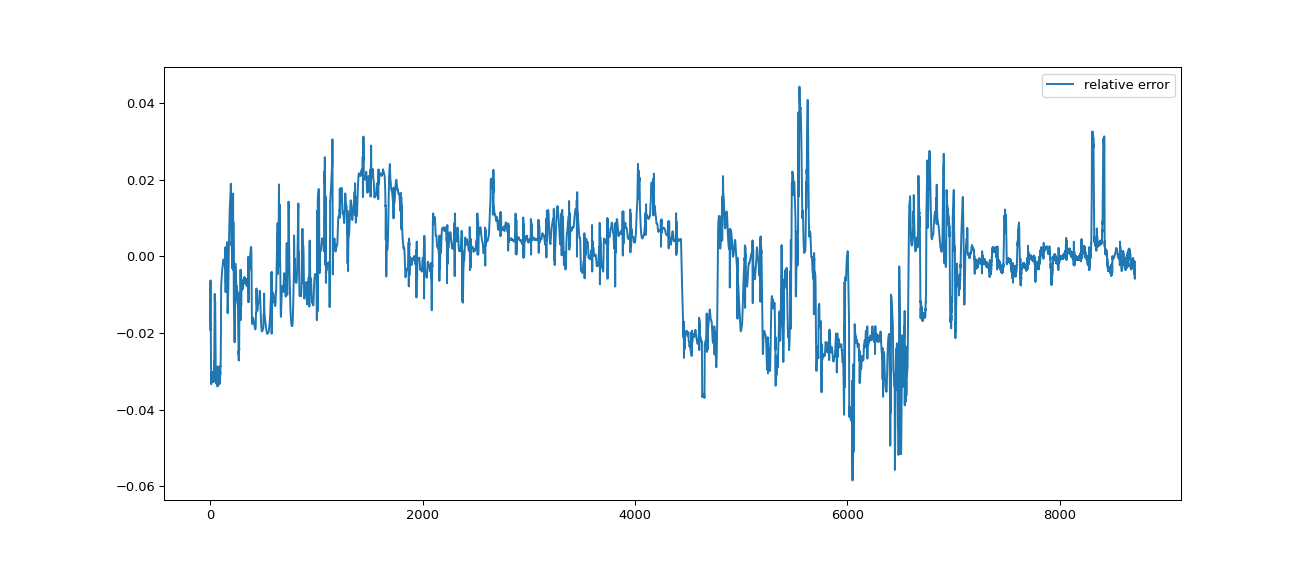

<IPython.core.display.Javascript object>


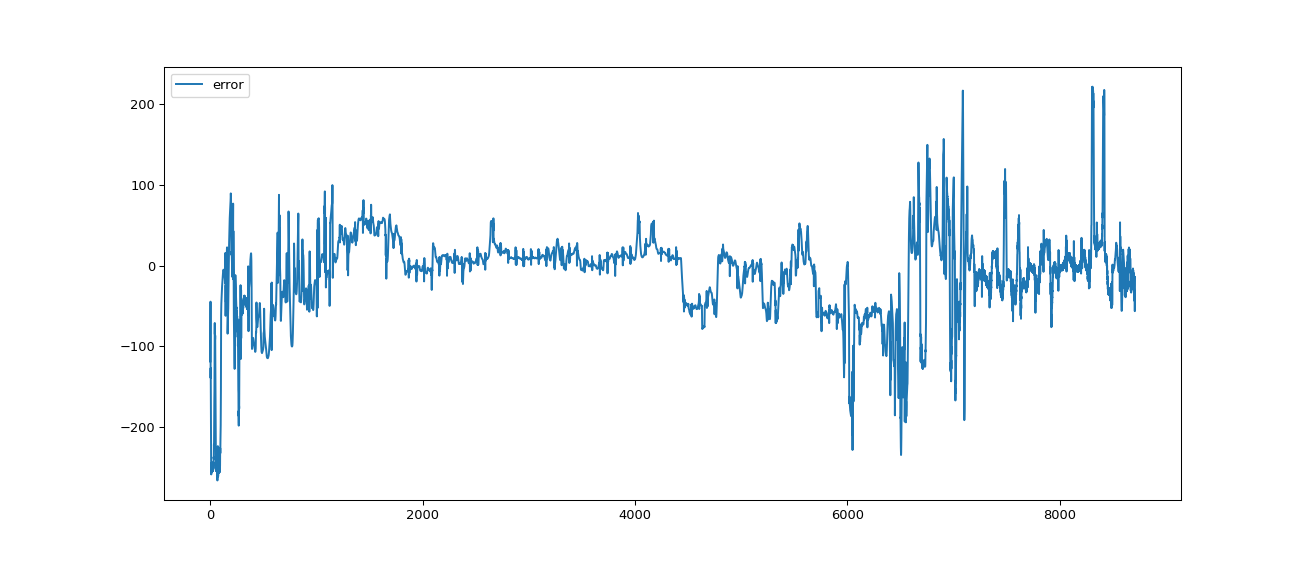

<IPython.core.display.Javascript object>


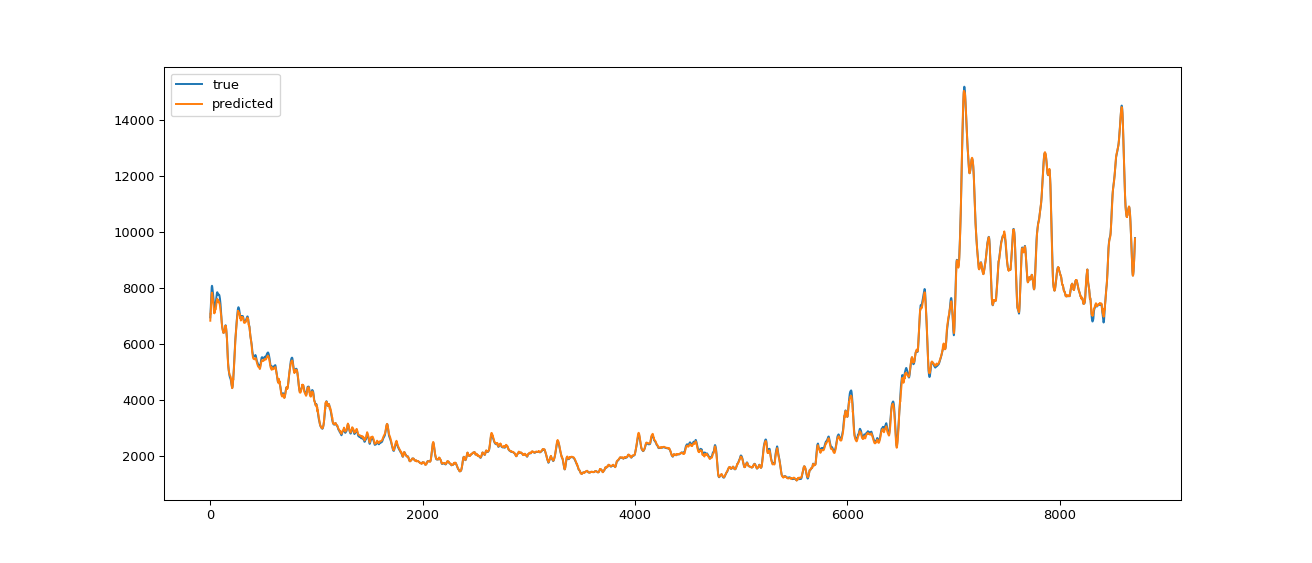

-------------------------------
Done
-------------------------------


In [31]:
#estimation in train_iter_normal

%matplotlib notebook
print(f'-------------------------------\n'
      f'Predicting\n'
      f'-------------------------------')

Ys, Y_hats = predict_noslide(net, train_iter_normal, loss=nn.MSELoss(reduction='mean'), device=device)

Ys = scaler_Q.inverse_transform(np.array(Ys).reshape(-1, 1))
Y_hats = scaler_Q.inverse_transform(np.array(Y_hats).reshape(-1, 1))

plt.figure(figsize=(14, 6))
error = Y_hats - Ys
error_relative = error / Ys

plt.plot(error_relative, color='tab:blue', label='relative error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(error, color='tab:blue', label='error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Ys, color='tab:blue', label='true')
plt.plot(Y_hats, color='tab:orange', label='predicted')
plt.legend()
plt.show()


print(f'-------------------------------\n'
      f'Done\n'
      f'-------------------------------')

-------------------------------
Predicting
-------------------------------


<IPython.core.display.Javascript object>


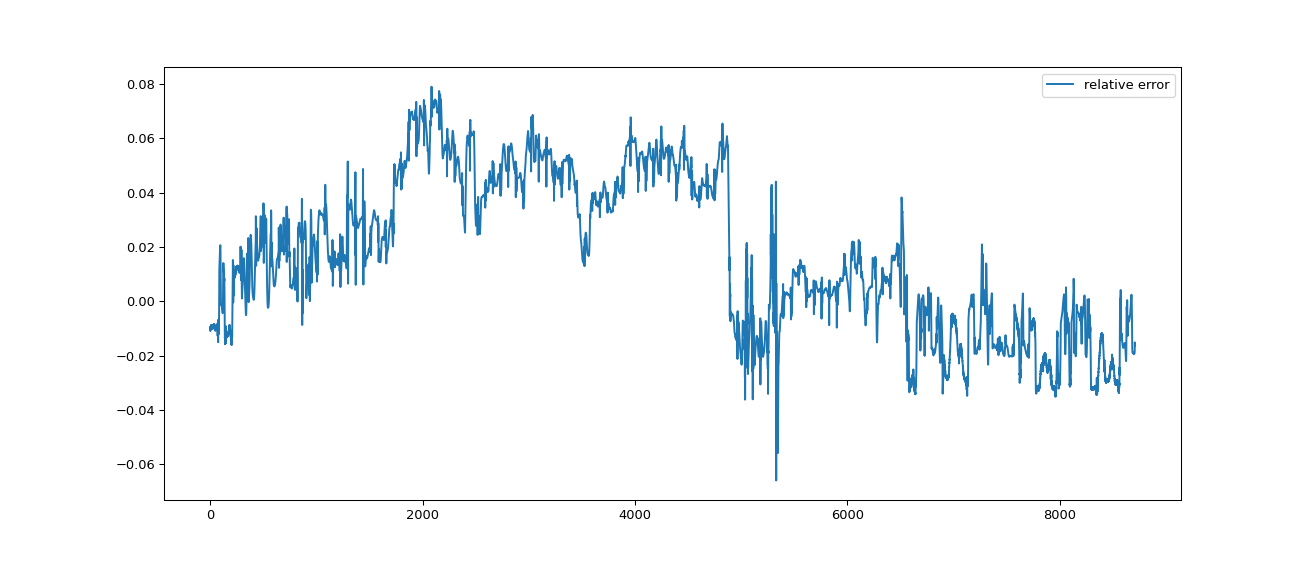

<IPython.core.display.Javascript object>


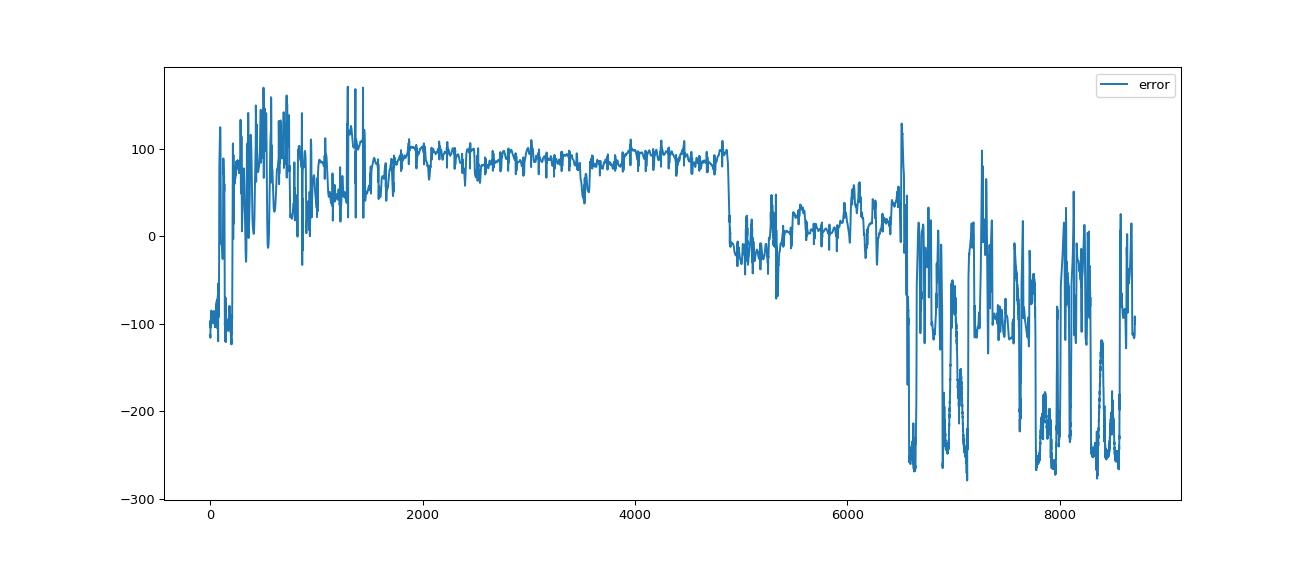

<IPython.core.display.Javascript object>


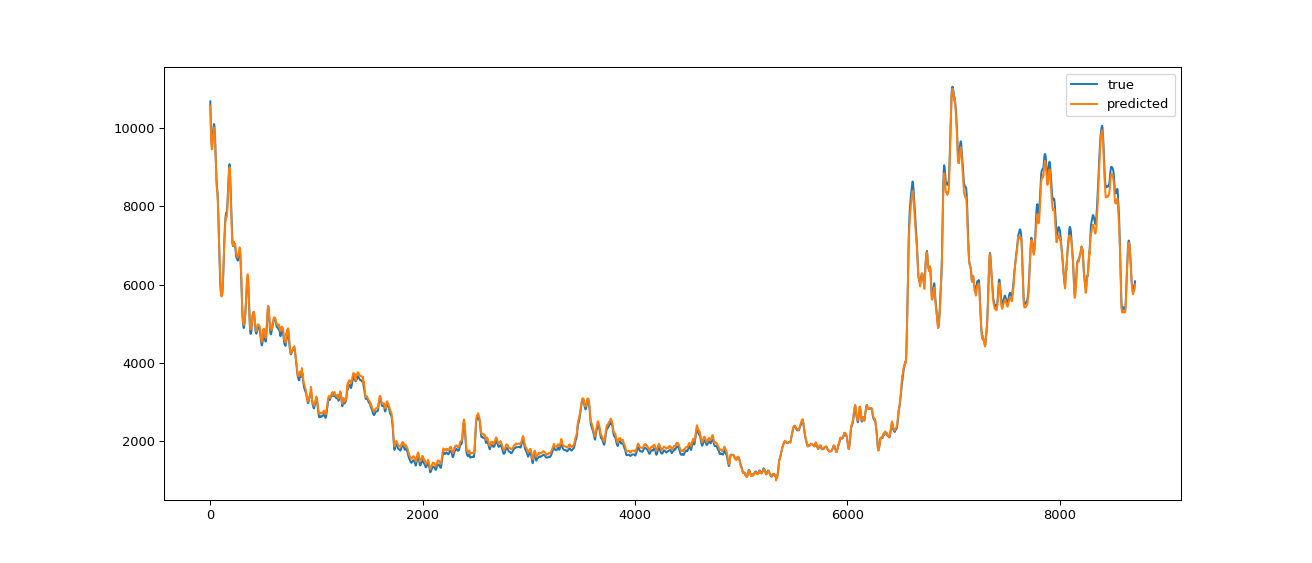

-------------------------------
Done
-------------------------------


In [33]:
#estimation in test_iter_normal

%matplotlib notebook
print(f'-------------------------------\n'
      f'Predicting\n'
      f'-------------------------------')

Ys, Y_hats = predict_noslide(net, test_iter_normal, loss=nn.MSELoss(reduction='mean'), device=device)

Ys = scaler_Q.inverse_transform(np.array(Ys).reshape(-1, 1))
Y_hats = scaler_Q.inverse_transform(np.array(Y_hats).reshape(-1, 1))

plt.figure(figsize=(14, 6))
error = Y_hats - Ys
error_relative = error / Ys

plt.plot(error_relative, color='tab:blue', label='relative error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(error, color='tab:blue', label='error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Ys, color='tab:blue', label='true')
plt.plot(Y_hats, color='tab:orange', label='predicted')
plt.legend()
plt.show()


print(f'-------------------------------\n'
      f'Done\n'
      f'-------------------------------')